In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Dataset

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [4]:
df = df.resample("W").mean()

<AxesSubplot: xlabel='Date'>

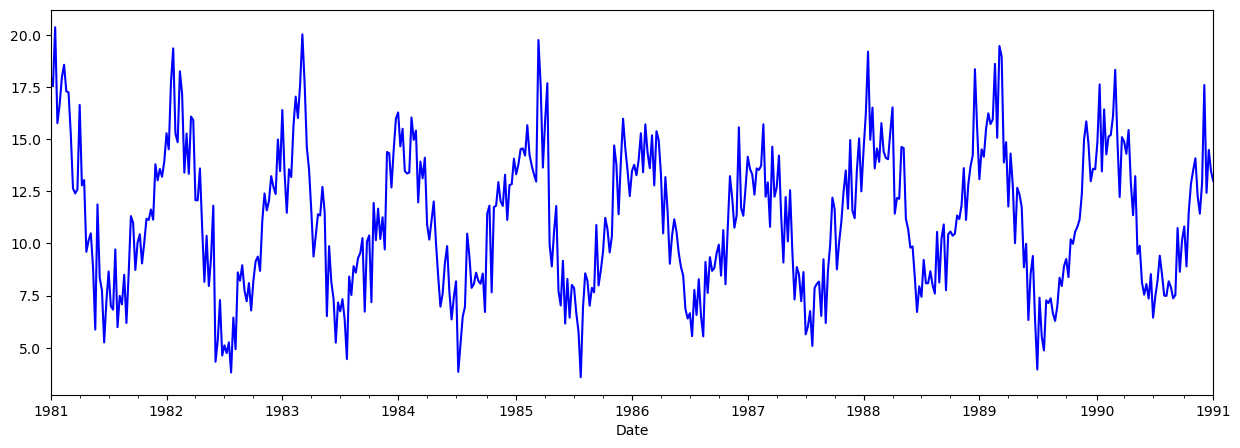

In [5]:
df.Temp.plot(figsize=(15, 5), color="b")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Dataloader

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [8]:
seq_len = 6
bs = 16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)  

(N, S, F): (69, 6, 1)
Note: last 3 data excluded

(N, S, F): (17, 6, 1)
Note: last 2 data excluded



# Arsitektur & Config

In [9]:
from jcopdl.layers import linear_block

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout) :
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [11]:
config = set_config({
    "input_size" : train_set.n_feature, 
    "output_size" : 1,
    "hidden_size" : 64,
    "num_layers" : 2,
    "dropout" : 0,
    "seq_len" :  train_set.n_seq    
})

# Training Preparation -> MCOC

In [12]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 125.1035 | Test_cost  = 115.0910 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 99.5647 | Test_cost  = 93.2764 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 80.5948 | Test_cost  = 77.0991 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 66.7850 | Test_cost  = 65.9822 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 57.4322 | Test_cost  = 58.4176 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 50.8524 | Test_cost  = 52.6289 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 45.6685 | Test_cost  = 47.8191 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 41.3141 | Test_cost  = 43.6528 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 37.5233 | Test_cost  = 39.9545 | 


Train:   0%|          | 0/5 [02:40<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 34.1633 | Test_cost  = 36.6452 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 31.1700 | Test_cost  = 33.6797 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 28.5024 | Test_cost  = 31.0247 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 26.1294 | Test_cost  = 28.6541 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 24.0262 | Test_cost  = 26.5461 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 22.1709 | Test_cost  = 24.6802 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 20.5427 | Test_cost  = 23.0358 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 19.1208 | Test_cost  = 21.5926 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 17.8851 | Test_cost  = 20.3312 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 16.8164 | Test_cost  = 19.2329 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 15.8966 | Test_cost  = 18.2802 | 


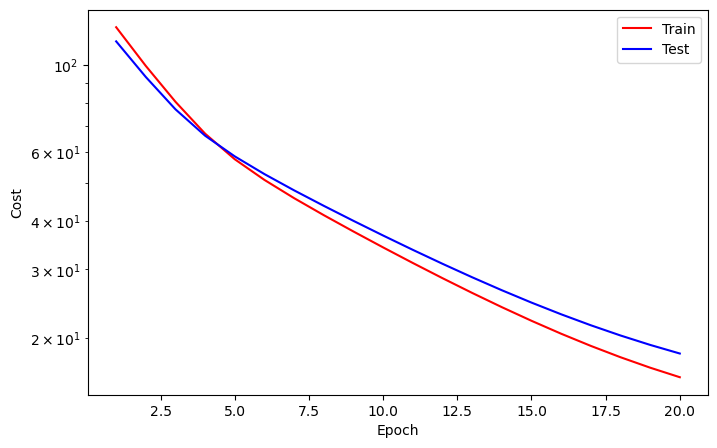

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 15.1088 | Test_cost  = 17.4568 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 14.4371 | Test_cost  = 16.7475 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [01:00<?, ?it/s]


Epoch    23
Train_cost  = 13.8671 | Test_cost  = 16.1384 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 13.3855 | Test_cost  = 15.6169 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 12.9804 | Test_cost  = 15.1716 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 12.6411 | Test_cost  = 14.7923 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 12.3581 | Test_cost  = 14.4699 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 12.1228 | Test_cost  = 14.1964 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 11.9281 | Test_cost  = 13.9647 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 11.7674 | Test_cost  = 13.7687 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 11.6352 | Test_cost  = 13.6031 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 11.5268 | Test_cost  = 13.4631 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 11.4381 | Test_cost  = 13.3449 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 11.3656 | Test_cost  = 13.2450 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 11.3064 | Test_cost  = 13.1606 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 11.2582 | Test_cost  = 13.0892 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 11.2189 | Test_cost  = 13.0286 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 11.1868 | Test_cost  = 12.9772 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 11.1605 | Test_cost  = 12.9334 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 11.1389 | Test_cost  = 12.8961 | 


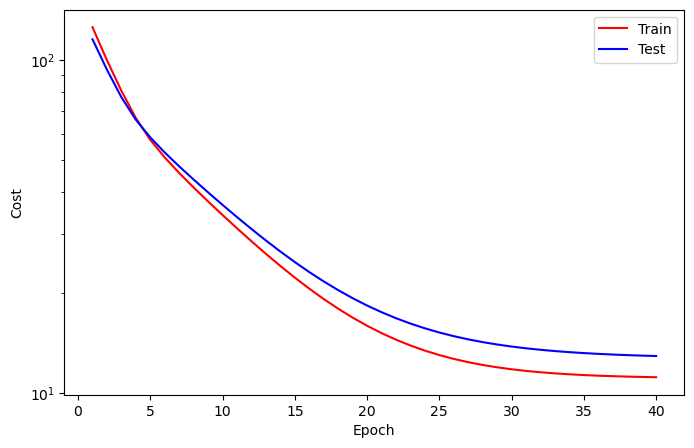

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 11.1211 | Test_cost  = 12.8641 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 11.1063 | Test_cost  = 12.8366 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 11.0939 | Test_cost  = 12.8130 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 11.0835 | Test_cost  = 12.7924 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 11.0747 | Test_cost  = 12.7746 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 11.0670 | Test_cost  = 12.7589 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 11.0603 | Test_cost  = 12.7451 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 11.0544 | Test_cost  = 12.7327 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 11.0491 | Test_cost  = 12.7217 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 11.0442 | Test_cost  = 12.7117 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 11.0397 | Test_cost  = 12.7024 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 11.0354 | Test_cost  = 12.6939 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 11.0312 | Test_cost  = 12.6857 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 11.0270 | Test_cost  = 12.6779 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 11.0228 | Test_cost  = 12.6703 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 11.0184 | Test_cost  = 12.6626 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 11.0136 | Test_cost  = 12.6546 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11.0082 | Test_cost  = 12.6460 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11.0018 | Test_cost  = 12.6364 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 10.9936 | Test_cost  = 12.6247 | 


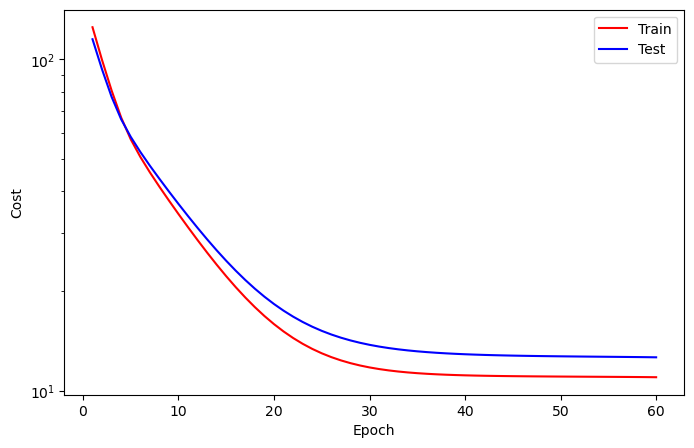

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 10.9822 | Test_cost  = 12.6095 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 10.9644 | Test_cost  = 12.5871 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 10.9320 | Test_cost  = 12.5560 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 10.8802 | Test_cost  = 12.5393 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 10.8260 | Test_cost  = 12.5318 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 10.7751 | Test_cost  = 12.4773 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 10.6983 | Test_cost  = 12.3282 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 10.6086 | Test_cost  = 12.2112 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 10.5280 | Test_cost  = 12.1087 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 10.4196 | Test_cost  = 11.9743 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 10.2334 | Test_cost  = 11.6564 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 9.8178 | Test_cost  = 11.1300 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 9.2828 | Test_cost  = 10.6082 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 8.7645 | Test_cost  = 10.1754 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 8.4683 | Test_cost  = 9.8549 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 8.1921 | Test_cost  = 9.5714 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 7.9456 | Test_cost  = 9.2580 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 7.6743 | Test_cost  = 8.9704 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 7.4278 | Test_cost  = 8.6467 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 7.1785 | Test_cost  = 8.3558 | 


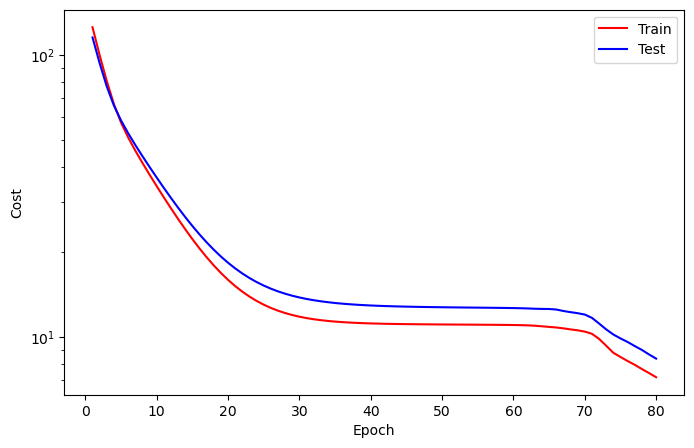

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 6.9378 | Test_cost  = 8.0357 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 6.7078 | Test_cost  = 7.7424 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 6.4858 | Test_cost  = 7.4557 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 6.2891 | Test_cost  = 7.1892 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 6.1045 | Test_cost  = 6.9572 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 5.9416 | Test_cost  = 6.7391 | 


Train:   0%|          | 0/5 [02:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 5.7932 | Test_cost  = 6.5494 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 5.6535 | Test_cost  = 6.3691 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 5.5241 | Test_cost  = 6.2030 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 5.3995 | Test_cost  = 6.0437 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 5.2815 | Test_cost  = 5.8884 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 5.1678 | Test_cost  = 5.7377 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 5.0576 | Test_cost  = 5.5875 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 4.9518 | Test_cost  = 5.4409 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 4.8496 | Test_cost  = 5.2956 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 4.7531 | Test_cost  = 5.1545 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 4.6619 | Test_cost  = 5.0179 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 4.5775 | Test_cost  = 4.8880 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 4.5000 | Test_cost  = 4.7662 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 4.4293 | Test_cost  = 4.6532 | 


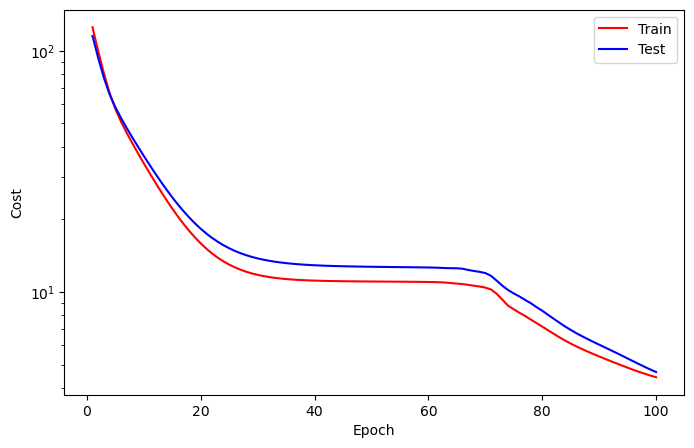

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 4.3652 | Test_cost  = 4.5498 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 4.3065 | Test_cost  = 4.4557 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 4.2529 | Test_cost  = 4.3706 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 4.2035 | Test_cost  = 4.2938 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 4.1580 | Test_cost  = 4.2241 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 4.1160 | Test_cost  = 4.1606 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 4.0774 | Test_cost  = 4.1021 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 4.0418 | Test_cost  = 4.0480 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 4.0091 | Test_cost  = 3.9977 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 3.9788 | Test_cost  = 3.9507 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 3.9509 | Test_cost  = 3.9068 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 3.9249 | Test_cost  = 3.8661 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 3.9008 | Test_cost  = 3.8281 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 3.8782 | Test_cost  = 3.7929 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 3.8571 | Test_cost  = 3.7601 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 3.8371 | Test_cost  = 3.7296 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 3.8183 | Test_cost  = 3.7011 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 3.8004 | Test_cost  = 3.6743 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 3.7834 | Test_cost  = 3.6492 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 3.7671 | Test_cost  = 3.6255 | 


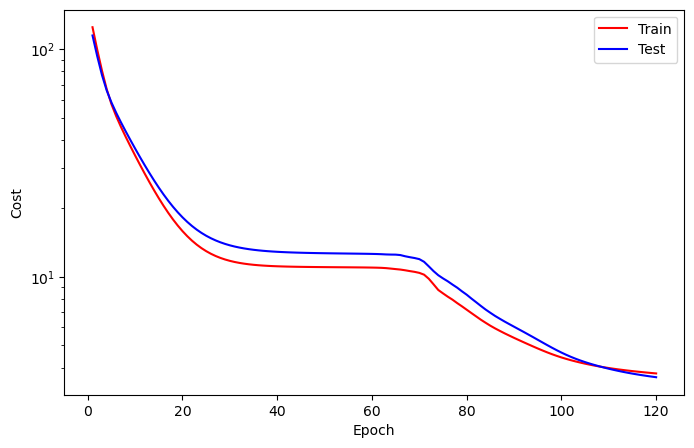

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 3.7515 | Test_cost  = 3.6032 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 3.7365 | Test_cost  = 3.5821 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 3.7221 | Test_cost  = 3.5623 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 3.7082 | Test_cost  = 3.5436 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 3.6947 | Test_cost  = 3.5260 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 3.6816 | Test_cost  = 3.5095 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 3.6689 | Test_cost  = 3.4939 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 3.6565 | Test_cost  = 3.4793 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 3.6444 | Test_cost  = 3.4655 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 3.6325 | Test_cost  = 3.4526 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 3.6208 | Test_cost  = 3.4405 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 3.6093 | Test_cost  = 3.4293 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 3.5980 | Test_cost  = 3.4187 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 3.5868 | Test_cost  = 3.4089 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 3.5758 | Test_cost  = 3.3997 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 3.5649 | Test_cost  = 3.3911 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 3.5542 | Test_cost  = 3.3831 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 3.5436 | Test_cost  = 3.3756 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 3.5332 | Test_cost  = 3.3684 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 3.5229 | Test_cost  = 3.3616 | 


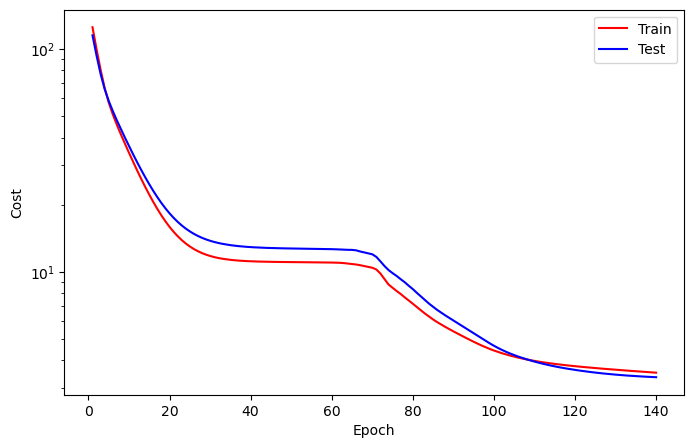

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 3.5128 | Test_cost  = 3.3550 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 3.5030 | Test_cost  = 3.3485 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 3.4933 | Test_cost  = 3.3422 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 3.4838 | Test_cost  = 3.3359 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 3.4745 | Test_cost  = 3.3297 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 3.4654 | Test_cost  = 3.3235 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 3.4566 | Test_cost  = 3.3174 | 


Train:   0%|          | 0/5 [02:20<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 3.4480 | Test_cost  = 3.3113 | 


Train:   0%|          | 0/5 [02:21<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 3.4395 | Test_cost  = 3.3052 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 3.4312 | Test_cost  = 3.2991 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 3.4232 | Test_cost  = 3.2932 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 3.4153 | Test_cost  = 3.2872 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 3.4076 | Test_cost  = 3.2814 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 3.4001 | Test_cost  = 3.2757 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 3.3927 | Test_cost  = 3.2700 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 3.3855 | Test_cost  = 3.2645 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 3.3785 | Test_cost  = 3.2590 | 


Train:   0%|          | 0/5 [02:40<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 3.3716 | Test_cost  = 3.2537 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 3.3649 | Test_cost  = 3.2485 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 3.3583 | Test_cost  = 3.2434 | 


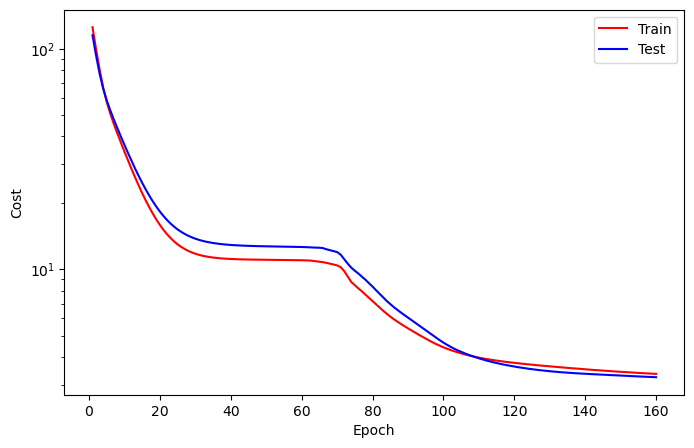

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 3.3519 | Test_cost  = 3.2384 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 3.3456 | Test_cost  = 3.2336 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 3.3395 | Test_cost  = 3.2288 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 3.3335 | Test_cost  = 3.2242 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 3.3276 | Test_cost  = 3.2198 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 3.3218 | Test_cost  = 3.2154 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 3.3162 | Test_cost  = 3.2112 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 3.3107 | Test_cost  = 3.2072 | 


Train:   0%|          | 0/5 [02:40<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 3.3053 | Test_cost  = 3.2032 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 3.3000 | Test_cost  = 3.1994 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 3.2948 | Test_cost  = 3.1957 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 3.2897 | Test_cost  = 3.1922 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 3.2847 | Test_cost  = 3.1887 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 3.2798 | Test_cost  = 3.1854 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 3.2750 | Test_cost  = 3.1822 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 3.2703 | Test_cost  = 3.1792 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 3.2657 | Test_cost  = 3.1762 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 3.2612 | Test_cost  = 3.1733 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 3.2567 | Test_cost  = 3.1706 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 3.2523 | Test_cost  = 3.1680 | 


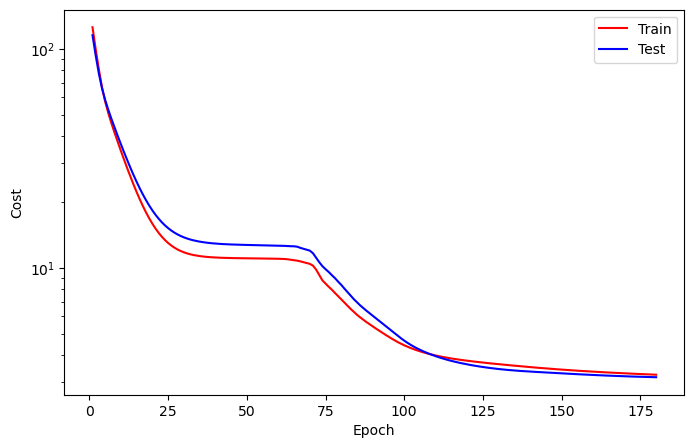

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 3.2480 | Test_cost  = 3.1654 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 3.2438 | Test_cost  = 3.1630 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 3.2396 | Test_cost  = 3.1606 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 3.2355 | Test_cost  = 3.1584 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 3.2315 | Test_cost  = 3.1562 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 3.2275 | Test_cost  = 3.1541 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 3.2235 | Test_cost  = 3.1521 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 3.2197 | Test_cost  = 3.1502 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 3.2158 | Test_cost  = 3.1483 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 3.2121 | Test_cost  = 3.1465 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 3.2083 | Test_cost  = 3.1448 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 3.2047 | Test_cost  = 3.1432 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 3.2010 | Test_cost  = 3.1417 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 3.1974 | Test_cost  = 3.1402 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 3.1939 | Test_cost  = 3.1388 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 3.1904 | Test_cost  = 3.1375 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 3.1869 | Test_cost  = 3.1362 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 3.1835 | Test_cost  = 3.1350 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 3.1801 | Test_cost  = 3.1339 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 3.1768 | Test_cost  = 3.1328 | 


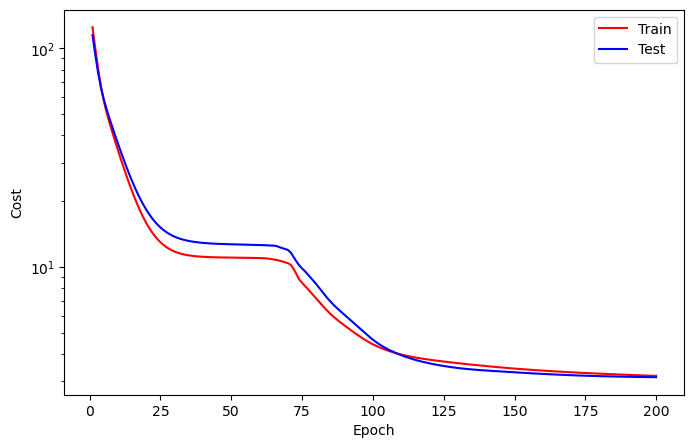

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 3.1734 | Test_cost  = 3.1318 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 3.1701 | Test_cost  = 3.1309 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 3.1668 | Test_cost  = 3.1301 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 3.1636 | Test_cost  = 3.1293 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 3.1604 | Test_cost  = 3.1286 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 3.1572 | Test_cost  = 3.1279 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 3.1540 | Test_cost  = 3.1273 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 3.1508 | Test_cost  = 3.1268 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 3.1477 | Test_cost  = 3.1263 | 


Train:   0%|          | 0/5 [03:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 3.1446 | Test_cost  = 3.1259 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 3.1415 | Test_cost  = 3.1256 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 3.1384 | Test_cost  = 3.1253 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 3.1353 | Test_cost  = 3.1250 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 3.1323 | Test_cost  = 3.1249 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 3.1292 | Test_cost  = 3.1247 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 3.1262 | Test_cost  = 3.1247 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 3.1232 | Test_cost  = 3.1247 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 3.1202 | Test_cost  = 3.1247 | 
==> EarlyStop patience =  1 | Best test_cost: 3.1247


Train:   0%|          | 0/5 [02:40<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 3.1172 | Test_cost  = 3.1248 | 
==> EarlyStop patience =  2 | Best test_cost: 3.1247


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 3.1142 | Test_cost  = 3.1249 | 


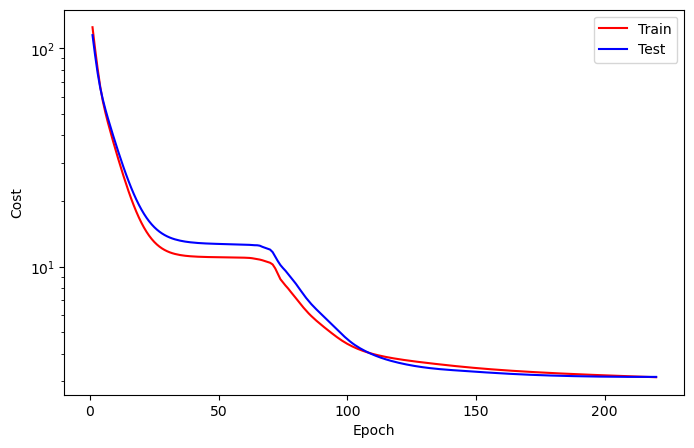

==> EarlyStop patience =  3 | Best test_cost: 3.1247


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 3.1113 | Test_cost  = 3.1251 | 
==> EarlyStop patience =  4 | Best test_cost: 3.1247


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 3.1083 | Test_cost  = 3.1253 | 
==> EarlyStop patience =  5 | Best test_cost: 3.1247
==> Execute Early Stopping at epoch: 222 | Best test_cost: 3.1247
==> Best model is saved at model/rnn


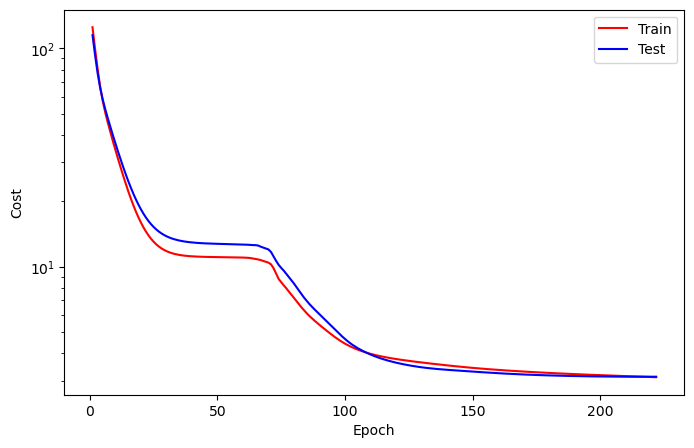

In [14]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
        
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [15]:
from luwiji.rnn import illustration

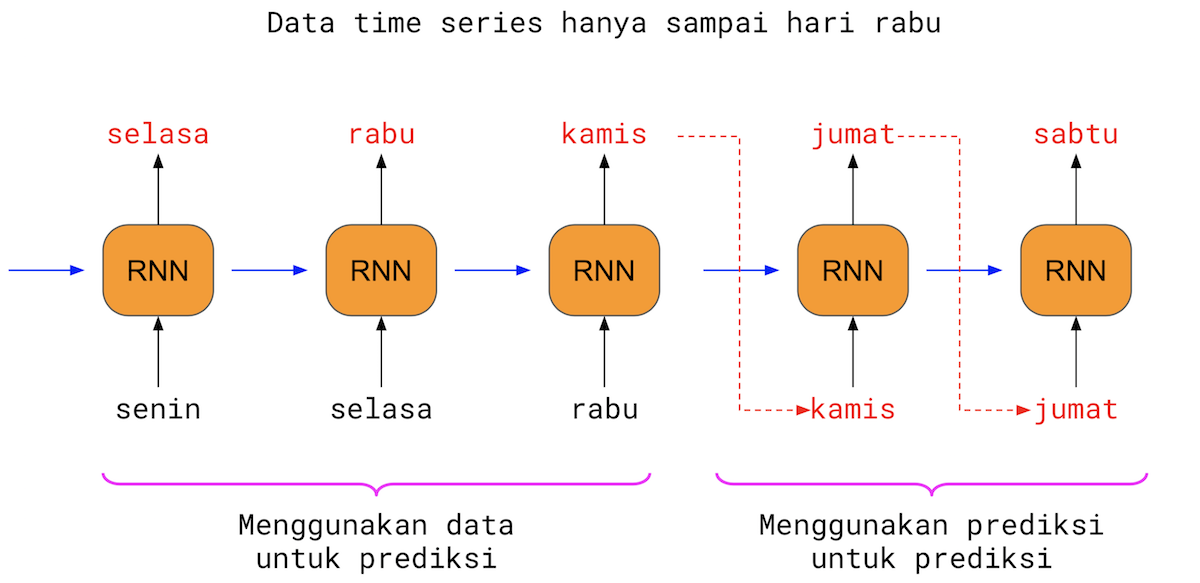

In [16]:
illustration.forecast

In [17]:
from utils import data4pred, pred4pred

In [19]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)  

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

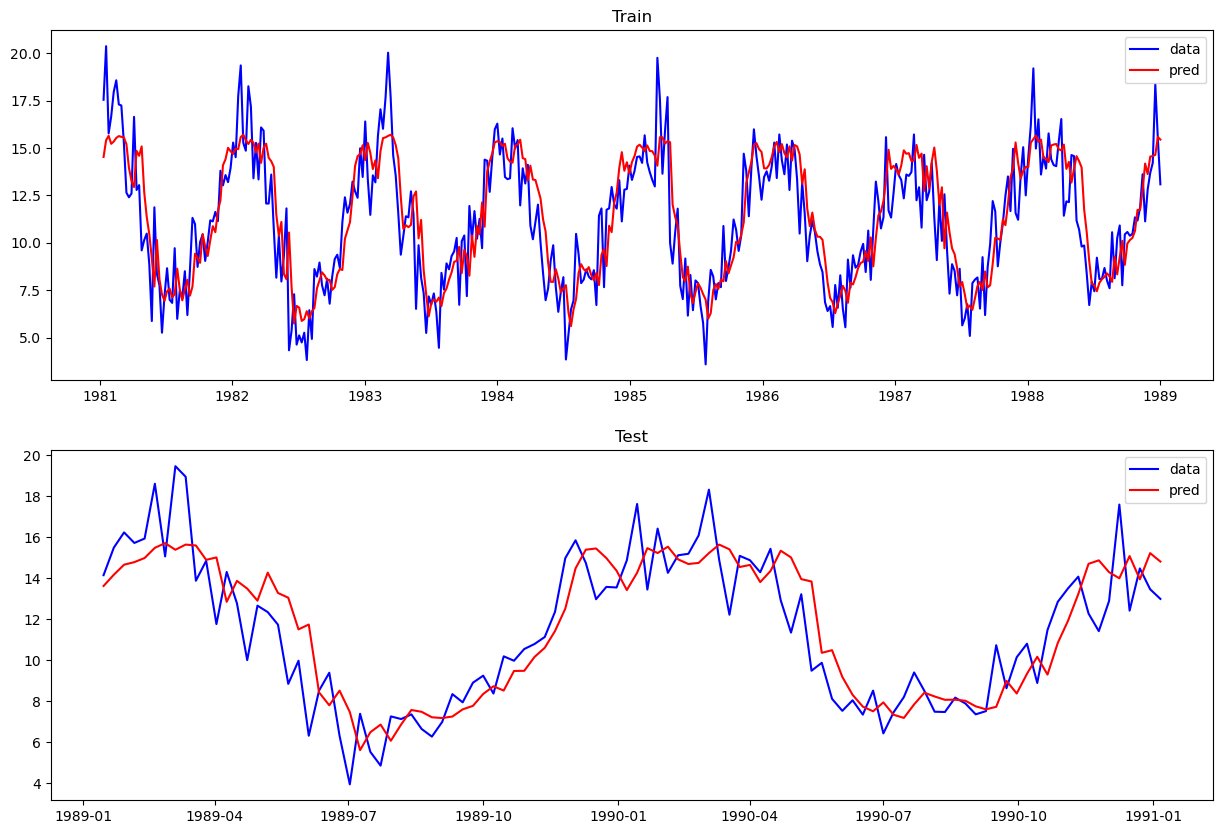

In [20]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

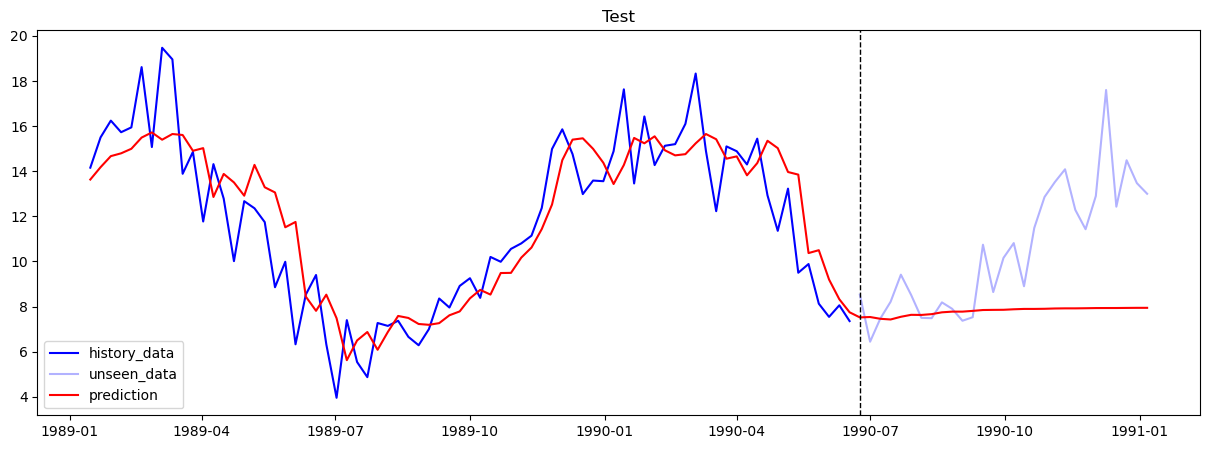

In [21]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");